Content image shape: torch.Size([1, 3, 266, 400])
Style image shape: torch.Size([1, 3, 266, 400])
Starting optimization...
Step 20: Content Loss: 58.1094, Style Loss: 209.5119, TV Loss: 0.0298
Step 40: Content Loss: 55.1335, Style Loss: 67.4147, TV Loss: 0.0322
Step 60: Content Loss: 49.5869, Style Loss: 37.5696, TV Loss: 0.0340
Step 80: Content Loss: 46.7919, Style Loss: 27.0872, TV Loss: 0.0352
Step 100: Content Loss: 45.1371, Style Loss: 21.6590, TV Loss: 0.0362
Step 120: Content Loss: 44.2927, Style Loss: 19.3993, TV Loss: 0.0367
Step 140: Content Loss: 43.5521, Style Loss: 17.7100, TV Loss: 0.0372
Step 160: Content Loss: 43.0271, Style Loss: 16.6335, TV Loss: 0.0376
Step 180: Content Loss: 42.6980, Style Loss: 16.0114, TV Loss: 0.0379
Step 200: Content Loss: 42.4068, Style Loss: 15.4647, TV Loss: 0.0382
Step 220: Content Loss: 42.2329, Style Loss: 15.1772, TV Loss: 0.0383
Step 240: Content Loss: 42.0909, Style Loss: 14.9254, TV Loss: 0.0384
Step 260: Content Loss: 41.9859, Style L

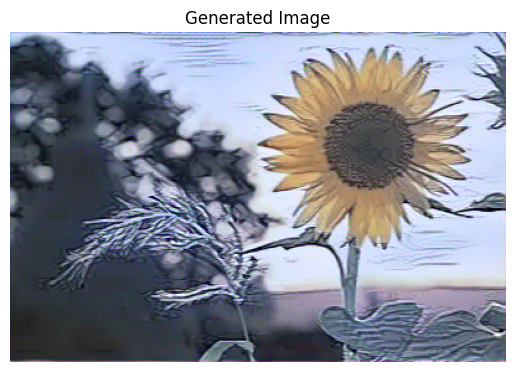

tensor([[[0.5931, 0.6635, 0.7201,  ..., 0.4823, 0.4939, 0.1560],
         [0.6820, 0.7786, 0.7704,  ..., 0.6726, 0.9078, 0.6851],
         [0.7292, 0.7820, 0.7625,  ..., 0.6233, 0.8526, 0.4989],
         ...,
         [0.0254, 0.0119, 0.0697,  ..., 0.1114, 0.3990, 0.1915],
         [0.2159, 0.3384, 0.3468,  ..., 0.5584, 0.8424, 0.6154],
         [0.3759, 0.2767, 0.1585,  ..., 0.4951, 0.6624, 0.2178]],

        [[0.7985, 0.6934, 0.6819,  ..., 0.6408, 0.4883, 0.3799],
         [0.8398, 0.8710, 0.8942,  ..., 0.8908, 0.5942, 0.6104],
         [0.8229, 0.8145, 0.9014,  ..., 0.8117, 0.7603, 0.6106],
         ...,
         [0.2504, 0.2139, 0.2131,  ..., 0.6078, 0.4858, 0.4474],
         [0.0916, 0.0819, 0.1402,  ..., 0.4835, 0.2802, 0.2724],
         [0.6381, 0.5320, 0.4802,  ..., 0.7002, 0.5831, 0.5912]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.5548, 0.6200, 0.8876],
         [1.0000, 1.0000, 1.0000,  ..., 0.9970, 0.9791, 1.0000],
         [1.0000, 0.9423, 0.8368,  ..., 0.9525, 0.8570, 1.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Load and transform image
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = (int(image.size[0] * scale), int(image.size[1] * scale))
        image = image.resize(size, Image.Resampling.LANCZOS)
    if shape:
        image = image.resize(shape, Image.Resampling.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)
    return image

# Normalize image inside the model
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = torch.tensor([0.0], requires_grad=True)

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

# Style loss
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()
        self.loss = torch.tensor([0.0], requires_grad=True)

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

    def gram_matrix(self, input):
        batch_size, channel, height, width = input.size()
        features = input.view(channel, height * width)
        G = torch.mm(features, features.t())
        return G.div(channel * height * width)

# Total Variation Loss
def total_variation_loss(img):
    return torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

# Main style transfer function
def style_transfer(content_path, style_path, num_steps=350, style_weight=100000, content_weight=5, tv_weight=1e-6, final_blend=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    max_size = 400

    # Load images
    content_img = load_image(content_path, max_size=max_size).to(device)
    style_img = load_image(style_path, shape=(content_img.shape[3], content_img.shape[2])).to(device)
    input_img = content_img.clone().requires_grad_(True)

    print(f"Content image shape: {content_img.shape}")
    print(f"Style image shape: {style_img.shape}")

    # VGG layers
    cnn = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
    normalization_mean = [0.485, 0.456, 0.406]
    normalization_std = [0.229, 0.224, 0.225]

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    model = nn.Sequential(normalization)
    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    # Trim model
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    optimizer = optim.Adam([input_img], lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    best_loss = float('inf')
    best_img = None

    print("Starting optimization...")

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()
        model(input_img)

        content_score = sum(cl.loss for cl in content_losses)
        style_score = sum(sl.loss for sl in style_losses)
        tv_score = total_variation_loss(input_img)

        content_score *= content_weight
        style_score *= style_weight
        tv_score *= tv_weight

        loss = content_score + style_score + tv_score

        if torch.isnan(loss):
            print(f"NaN detected at step {step}, using best previous result")
            if best_img is not None:
                input_img.data = best_img.data
            break

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_img = input_img.clone().detach()

        loss.backward()
        torch.nn.utils.clip_grad_norm_([input_img], max_norm=1.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            input_img.clamp_(0, 1)

        if step % 20 == 0:
            print(f"Step {step}: Content Loss: {content_score.item():.4f}, Style Loss: {style_score.item():.4f}, TV Loss: {tv_score.item():.4f}")

        if step % 100 == 0:
            output_img = input_img.clone().detach().squeeze(0).cpu()
            save_image(output_img, f'output_step_{step}.jpg')

    if best_img is not None:
        input_img.data = best_img.data

    # Optional blending
    if final_blend > 0.0:
        input_img.data = final_blend * content_img + (1 - final_blend) * input_img

    with torch.no_grad():
        input_img.clamp_(0, 1)

    output_img = input_img.squeeze(0).cpu()
    save_image(output_img, 'output.jpg')
    print("Generated image saved as 'output.jpg'")

    plt.figure()
    plt.imshow(output_img.permute(1, 2, 0).detach().numpy())
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()

    return output_img

# Example call
style_transfer(
    r'C:\Users\Rethanaya\Documents\lab proj\sunflower.jpg',
    r'C:\Users\Rethanaya\Documents\lab proj\girl.jpg',
    num_steps=400,
    style_weight=100000,
    content_weight=5,
    tv_weight=1e-6,
    final_blend=0.0  
)


Step 50: Content: 16.42, Style: 1026.20, TV: 0.03
Step 100: Content: 18.00, Style: 470.72, TV: 0.03
Step 150: Content: 18.78, Style: 282.87, TV: 0.04
Step 200: Content: 19.24, Style: 194.00, TV: 0.04
Step 250: Content: 19.53, Style: 145.77, TV: 0.04
Step 300: Content: 19.70, Style: 116.60, TV: 0.04
Step 350: Content: 19.80, Style: 97.52, TV: 0.04
Step 400: Content: 19.84, Style: 84.09, TV: 0.04
Generated image saved as 'output.jpg'
Denoised image saved as 'output_denoised.jpg'


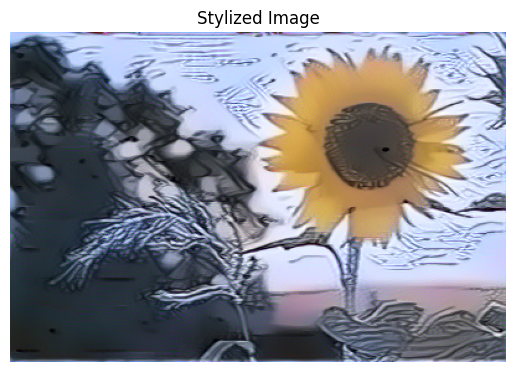

tensor([[[0.6655, 0.7586, 0.6553,  ..., 0.4453, 0.4275, 0.3058],
         [0.6794, 0.7777, 0.7614,  ..., 0.6342, 0.7604, 0.4745],
         [0.6816, 0.7373, 0.7225,  ..., 0.7860, 0.8833, 0.5320],
         ...,
         [0.2670, 0.1952, 0.1550,  ..., 0.2340, 0.2882, 0.3411],
         [0.5837, 0.4210, 0.3903,  ..., 0.5537, 0.6868, 0.5202],
         [0.3077, 0.3329, 0.2733,  ..., 0.6802, 0.6270, 0.4208]],

        [[0.8818, 0.7676, 0.8026,  ..., 0.6223, 0.6252, 0.4342],
         [0.8350, 0.7706, 0.7658,  ..., 0.7445, 0.5044, 0.5557],
         [0.8378, 0.7752, 0.8043,  ..., 0.8905, 0.8729, 0.6657],
         ...,
         [0.3932, 0.3702, 0.2456,  ..., 0.3028, 0.3033, 0.4141],
         [0.4274, 0.3304, 0.3620,  ..., 0.5882, 0.5940, 0.5320],
         [0.5308, 0.4697, 0.4514,  ..., 0.7599, 0.6767, 0.6921]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6689, 0.7038, 0.8765],
         [1.0000, 1.0000, 1.0000,  ..., 0.9410, 0.8038, 1.0000],
         [1.0000, 1.0000, 0.9415,  ..., 0.9972, 0.9185, 0.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import cv2
import numpy as np

# Load and transform image
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = (int(image.size[0] * scale), int(image.size[1] * scale))
        image = image.resize(size, Image.Resampling.LANCZOS)
    if shape:
        image = image.resize(shape, Image.Resampling.LANCZOS)
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image).unsqueeze(0)
    return image

# Normalize image inside the model
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

# Style loss
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

    def gram_matrix(self, input):
        b, c, h, w = input.size()
        features = input.view(c, h * w)
        G = torch.mm(features, features.t())
        return G / (c * h * w)

# Total Variation Loss
def total_variation_loss(img):
    return torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

# Optional: Apply bilateral filter
def denoise_and_save(img_tensor, path='final_output.jpg'):
    img = img_tensor.mul(255).byte().numpy().transpose(1, 2, 0)
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Style transfer function
def style_transfer(content_path, style_path, num_steps=300,
                   style_weight=1e6, content_weight=1e0, tv_weight=1e-6,
                   final_blend=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_img = load_image(content_path).to(device)
    style_img = load_image(style_path, shape=(content_img.shape[3], content_img.shape[2])).to(device)
    input_img = content_img.clone().requires_grad_(True)

    cnn = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
    normalization_mean = [0.485, 0.456, 0.406]
    normalization_std = [0.229, 0.224, 0.225]

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    model = nn.Sequential(normalization)
    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:(j + 1)]

    optimizer = optim.Adam([input_img], lr=0.01)
    best_loss = float('inf')
    best_img = None

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()
        model(input_img)

        content_score = sum(cl.loss for cl in content_losses)
        style_score = sum(sl.loss for sl in style_losses)
        tv_score = total_variation_loss(input_img)

        content_score *= content_weight
        style_score *= style_weight
        tv_score *= tv_weight

        loss = content_score + style_score + tv_score

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_img = input_img.clone().detach()

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            input_img.clamp_(0, 1)

        if step % 50 == 0:
            print(f"Step {step}: Content: {content_score.item():.2f}, Style: {style_score.item():.2f}, TV: {tv_score.item():.2f}")

    with torch.no_grad():
        input_img.data = best_img.data
        if final_blend > 0.0:
            input_img.data = final_blend * content_img + (1 - final_blend) * input_img
        input_img.clamp_(0, 1)

    output_img = input_img.squeeze(0).cpu()
    save_image(output_img, 'output.jpg')
    print("Generated image saved as 'output.jpg'")

    denoise_and_save(output_img, 'output_denoised.jpg')
    print("Denoised image saved as 'output_denoised.jpg'")

    plt.figure()
    plt.imshow(output_img.permute(1, 2, 0).detach().numpy())
    plt.title('Stylized Image')
    plt.axis('off')
    plt.show()

    return output_img

# Run style transfer
style_transfer(
    r'C:\Users\Rethanaya\Documents\lab proj\sunflower.jpg',
    r'C:\Users\Rethanaya\Documents\lab proj\girl.jpg',
    num_steps=400,
    style_weight=1e6,
    content_weight=1,
    tv_weight=1e-6,
    final_blend=0.0
)


Step 50: Content: 12.35, Style: 2268.19, TV: 0.04
Step 100: Content: 13.54, Style: 691.41, TV: 0.04
Step 150: Content: 13.75, Style: 269.87, TV: 0.04
Step 200: Content: 13.73, Style: 126.98, TV: 0.04
Step 250: Content: 13.60, Style: 70.38, TV: 0.04
Step 300: Content: 13.39, Style: 44.84, TV: 0.04
Step 350: Content: 13.13, Style: 31.94, TV: 0.04
Step 400: Content: 12.86, Style: 24.70, TV: 0.04
Generated image saved as 'output.jpg'
Denoised image saved as 'output_denoised.jpg'


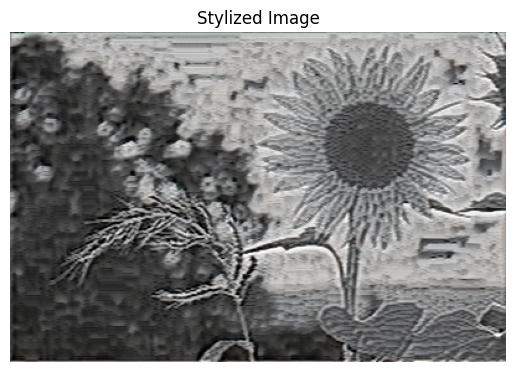

tensor([[[0.3644, 0.2127, 0.2455,  ..., 0.5748, 0.6196, 0.5257],
         [0.5232, 0.7309, 0.7987,  ..., 0.8021, 0.8058, 0.6687],
         [0.5968, 0.7270, 0.8086,  ..., 0.7664, 0.7581, 0.5601],
         ...,
         [0.2308, 0.0623, 0.0000,  ..., 0.3397, 0.2746, 0.1232],
         [0.3112, 0.1495, 0.0928,  ..., 0.5982, 0.4755, 0.3548],
         [0.3126, 0.5887, 0.6716,  ..., 0.7304, 0.7624, 0.5900]],

        [[0.2116, 0.3537, 0.3836,  ..., 0.6545, 0.6236, 0.5987],
         [0.5569, 0.7266, 0.7944,  ..., 0.8086, 0.7962, 0.7016],
         [0.6310, 0.7114, 0.8098,  ..., 0.7827, 0.7305, 0.5432],
         ...,
         [0.2165, 0.0845, 0.0000,  ..., 0.2370, 0.2439, 0.3223],
         [0.1989, 0.1194, 0.0737,  ..., 0.6055, 0.4344, 0.4403],
         [0.5077, 0.4214, 0.5556,  ..., 0.7322, 0.7344, 0.6807]],

        [[0.1568, 0.3609, 0.2954,  ..., 0.6730, 0.6569, 0.5892],
         [0.5880, 0.7171, 0.7546,  ..., 0.7676, 0.7621, 0.6487],
         [0.4795, 0.7312, 0.8241,  ..., 0.7995, 0.6900, 0.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import cv2
import numpy as np

# Load and transform image
def load_image(image_path, max_size=400, shape=None, grayscale=False):
    image = Image.open(image_path).convert('RGB')
    if grayscale:
        image = image.convert('L').convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = (int(image.size[0] * scale), int(image.size[1] * scale))
        image = image.resize(size, Image.Resampling.LANCZOS)
    if shape:
        image = image.resize(shape, Image.Resampling.LANCZOS)
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image).unsqueeze(0)
    return image

# Normalize image inside the model
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

# Style loss
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

    def gram_matrix(self, input):
        b, c, h, w = input.size()
        features = input.view(c, h * w)
        G = torch.mm(features, features.t())
        return G / (c * h * w)

# Total Variation Loss
def total_variation_loss(img):
    return torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

# Post-processing: sharpen + bilateral filter
def denoise_and_save(img_tensor, path='final_output.jpg'):
    img = img_tensor.mul(255).byte().numpy().transpose(1, 2, 0)
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

    # Sharpening filter
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Style transfer function
def style_transfer(content_path, style_path, num_steps=400,
                   style_weight=1e8, content_weight=1e0, tv_weight=1e-6,
                   final_blend=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load images in grayscale style
    content_img = load_image(content_path, grayscale=True).to(device)
    style_img = load_image(style_path, shape=(content_img.shape[3], content_img.shape[2]), grayscale=True).to(device)
    input_img = content_img.clone().requires_grad_(True)

    cnn = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
    normalization_mean = [0.485, 0.456, 0.406]
    normalization_std = [0.229, 0.224, 0.225]

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2']  # use earlier layers for texture

    model = nn.Sequential(normalization)
    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:(j + 1)]

    optimizer = optim.Adam([input_img], lr=0.01)
    best_loss = float('inf')
    best_img = None

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()
        model(input_img)

        content_score = sum(cl.loss for cl in content_losses)
        style_score = sum(sl.loss for sl in style_losses)
        tv_score = total_variation_loss(input_img)

        content_score *= content_weight
        style_score *= style_weight
        tv_score *= tv_weight

        loss = content_score + style_score + tv_score

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_img = input_img.clone().detach()

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            input_img.clamp_(0, 1)

        if step % 50 == 0:
            print(f"Step {step}: Content: {content_score.item():.2f}, Style: {style_score.item():.2f}, TV: {tv_score.item():.2f}")

    with torch.no_grad():
        input_img.data = best_img.data
        if final_blend > 0.0:
            input_img.data = final_blend * content_img + (1 - final_blend) * input_img
        input_img.clamp_(0, 1)

    output_img = input_img.squeeze(0).cpu()
    save_image(output_img, 'output.jpg')
    print("Generated image saved as 'output.jpg'")

    denoise_and_save(output_img, 'output_denoised.jpg')
    print("Denoised image saved as 'output_denoised.jpg'")

    plt.figure()
    plt.imshow(output_img.permute(1, 2, 0).detach().numpy())
    plt.title('Stylized Image')
    plt.axis('off')
    plt.show()

    return output_img

# Run style transfer
style_transfer(
    r'C:\Users\Rethanaya\Documents\lab proj\sunflower.jpg',
    r'C:\Users\Rethanaya\Documents\lab proj\art_girl.jpg',
    num_steps=400,
    style_weight=1e8,
    content_weight=1,
    tv_weight=1e-6,
    final_blend=0.0
)


Step 50: Content 15.38 | Style 236.75 | TV 0.0192
Step 100: Content 13.27 | Style 129.36 | TV 0.0178
Step 150: Content 12.45 | Style 94.22 | TV 0.0172
Step 200: Content 12.01 | Style 73.73 | TV 0.0169
Step 250: Content 11.68 | Style 59.73 | TV 0.0167
Step 300: Content 11.39 | Style 49.51 | TV 0.0167
Step 350: Content 11.08 | Style 41.71 | TV 0.0168
Step 400: Content 10.77 | Style 35.60 | TV 0.0168
Stylized image with style color saved as 'final_stylecolor_output.jpg'


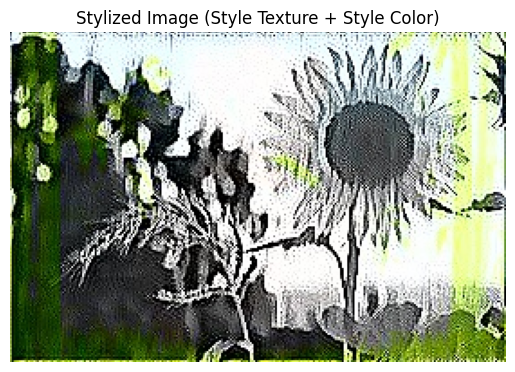

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import cv2
import numpy as np

# Load and transform image as tensor
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = (int(image.size[0] * scale), int(image.size[1] * scale))
        image = image.resize(size, Image.Resampling.LANCZOS)
    if shape:
        image = image.resize(shape, Image.Resampling.LANCZOS)
    transform = transforms.ToTensor()
    return transform(image).unsqueeze(0)

# Normalize image for VGG
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

# Style loss
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

    def gram_matrix(self, input):
        b, c, h, w = input.size()
        features = input.view(c, h * w)
        G = torch.mm(features, features.t())
        return G / (c * h * w)

# Total Variation Loss
def total_variation_loss(img):
    return torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

# Post-processing: merge stylized luminance with STYLE image color
def postprocess_ycbcr(stylized_y, style_ycbcr, path='final_stylecolor_output.jpg'):
    y = stylized_y.squeeze().cpu().clamp(0, 1).numpy()
    y = (y * 255).astype(np.uint8)

    # Resize Cb and Cr to match Y
    height, width = y.shape
    cb = cv2.resize(style_ycbcr[:, :, 1], (width, height), interpolation=cv2.INTER_CUBIC)
    cr = cv2.resize(style_ycbcr[:, :, 2], (width, height), interpolation=cv2.INTER_CUBIC)

    ycbcr = cv2.merge([y, cb, cr])
    rgb = cv2.cvtColor(ycbcr, cv2.COLOR_YCrCb2RGB)

    # Optional sharpening
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    rgb = cv2.filter2D(rgb, -1, kernel)

    cv2.imwrite(path, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    print(f"Stylized image with style color saved as '{path}'")


# Style transfer on luminance
def style_transfer_luminance_with_style_color(content_path, style_path, num_steps=400,
                                              style_weight=1e7, content_weight=1, tv_weight=1e-6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load images using OpenCV
    content_bgr = cv2.imread(content_path)
    style_bgr = cv2.imread(style_path)

    content_ycbcr = cv2.cvtColor(content_bgr, cv2.COLOR_BGR2YCrCb)
    style_ycbcr = cv2.cvtColor(style_bgr, cv2.COLOR_BGR2YCrCb)

    content_y = content_ycbcr[:, :, 0]
    style_y = style_ycbcr[:, :, 0]

    # Convert to PIL RGB for grayscale Y
    content_y_pil = Image.fromarray(content_y).convert('RGB')
    style_y_pil = Image.fromarray(style_y).convert('RGB')
    style_y_pil = style_y_pil.resize(content_y_pil.size, Image.Resampling.LANCZOS)

    transform = transforms.ToTensor()
    content_tensor = transform(content_y_pil).unsqueeze(0).to(device)
    style_tensor = transform(style_y_pil).unsqueeze(0).to(device)
    input_tensor = content_tensor.clone().requires_grad_(True)

    # VGG features
    cnn = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
    normalization = Normalization([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2']

    model = nn.Sequential(normalization)
    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_tensor).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_tensor).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:(j + 1)]

    optimizer = optim.Adam([input_tensor], lr=0.01)
    best_img = None
    best_loss = float('inf')

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()
        model(input_tensor)

        content_score = sum(cl.loss for cl in content_losses)
        style_score = sum(sl.loss for sl in style_losses)
        tv_score = total_variation_loss(input_tensor)

        content_score *= content_weight
        style_score *= style_weight
        tv_score *= tv_weight

        loss = content_score + style_score + tv_score

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_img = input_tensor.clone().detach()

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            input_tensor.clamp_(0, 1)

        if step % 50 == 0:
            print(f"Step {step}: Content {content_score.item():.2f} | Style {style_score.item():.2f} | TV {tv_score.item():.4f}")

    # Use best luminance with STYLE image color
    stylized_y = best_img.squeeze().cpu().clamp(0, 1)[0].unsqueeze(0)
    postprocess_ycbcr(stylized_y, style_ycbcr, path='final_stylecolor_output.jpg')

    # Show final result
    img_bgr = cv2.imread('final_stylecolor_output.jpg')
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Stylized Image (Style Texture + Style Color)")
    plt.show()

# Run
style_transfer_luminance_with_style_color(
    r'C:\Users\Rethanaya\Documents\lab proj\sunflower.jpg',
    r'C:\Users\Rethanaya\Documents\lab proj\panda.jpg',
    num_steps=400,
    style_weight=1e7,
    content_weight=1,
    tv_weight=1e-6
)
